In [1]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D,Input,concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
images = r"D:\Balance\College and Studies\TY\CV & DL Lab\CVDL Dataset\semantic segmentation\Images"
labels = r"D:\Balance\College and Studies\TY\CV & DL Lab\CVDL Dataset\semantic segmentation\Labels"

In [3]:
def load_images_and_masks(image_dir, label_dir, image_size):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))  # Sort to ensure matching order
    label_files = sorted(os.listdir(label_dir))  # Sort to ensure matching order

    for img_file, mask_file in zip(image_files, label_files):
        # Load and preprocess image
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(label_dir, mask_file)

        img = load_img(img_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")

        images.append(img_to_array(img) / 255.0)  # Normalize images to [0, 1]
        masks.append(img_to_array(mask) / 255.0)  # Normalize masks to [0, 1]

    return np.array(images), np.array(masks)

images, masks = load_images_and_masks(images, labels, (128,128))

In [4]:
num_classes = 2
masks = np.round(masks).astype("int")  # Ensure masks are binary
masks = to_categorical(masks, num_classes=num_classes)

In [5]:
print(masks.shape)

(179, 128, 128, 2)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)

(143, 128, 128, 3)
(36, 128, 128, 3)
(143, 128, 128, 2)


In [8]:
def unet_model(input_size=(128, 128, 3), num_classes=num_classes):
    inputs = Input(input_size)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (Expanding Path)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = unet_model(input_size=(128, 128, 3))



In [9]:


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=1
)

5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.5750 - loss: 0.7141 - val_accuracy: 0.5819 - val_loss: 0.7120


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


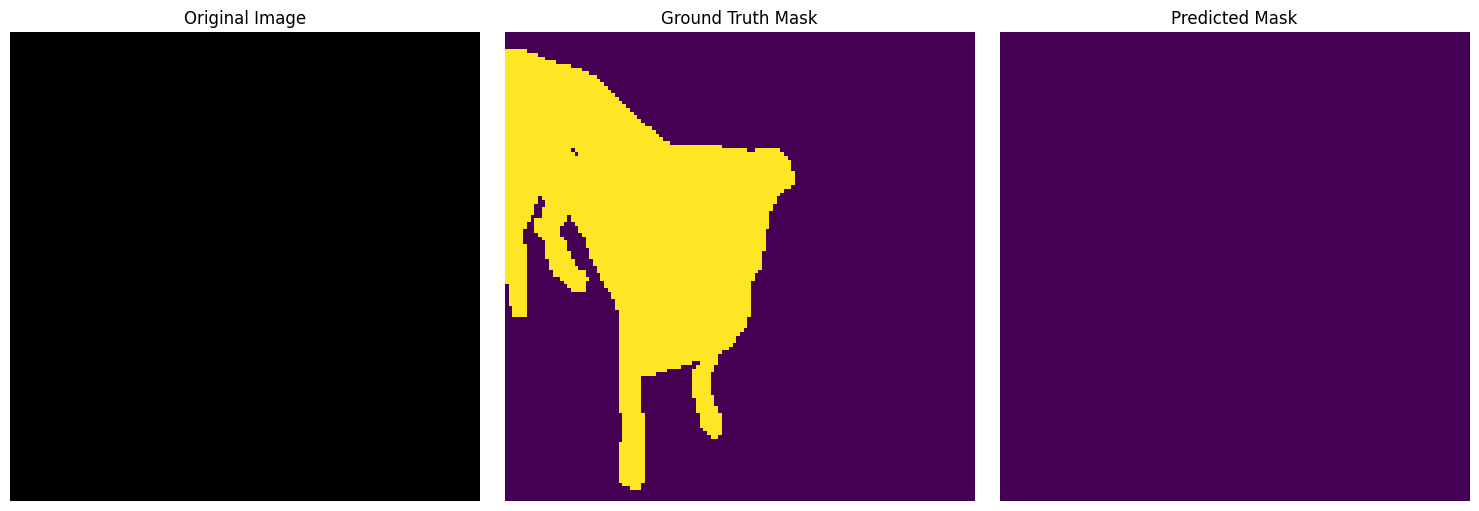

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Randomly select an image from X_val
random_index = 4
random_image = X_val[random_index]
random_image = np.expand_dims(random_image / 255.0, axis=0)  # Normalize image

# Predict segmentation mask
predicted_mask = model.predict(random_image)  # Output shape: (1, height, width, num_classes)
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert softmax to class indices
predicted_mask = predicted_mask.squeeze()  # Remove batch dimension

# Display the original image, true mask, and predicted mask
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(random_image.squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
true_mask = y_val[random_index]  # Ground truth mask
# Check if true_mask has multiple channels (multi-class)
if true_mask.shape[-1] > 1:  # Check if the mask has more than one channel
    true_mask = np.argmax(true_mask, axis=-1)  # Convert to single class (for display)
    true_mask = np.expand_dims(true_mask, axis=-1)  # Ensure it has the correct shape for display

plt.imshow(true_mask.squeeze(), cmap='viridis')  # Better colormap for class labels
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
